### Import & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
from pathlib import Path
project_dir = Path().resolve().parent
sys.path.append(str(project_dir))

In [3]:
from data.db_utils import get_connection
from model.fit_pred import score_reg_pred
from model.model_evaluator import RegressionEvaluator

reg_eval = RegressionEvaluator()

### Load data

In [4]:
DB_PATH = '../data/crypto_data.db'
conn = get_connection(DB_PATH)

symbol = 'ETHUSDT'

In [5]:
query = f""" 
    SELECT
    a.datetime, a.symbol, a.actuals, a.predicted,
    b.open, b.high, b.low, b.close, b.volume
    FROM
    (SELECT * 
    FROM signals
    WHERE symbol='{symbol}'
    ORDER BY datetime DESC) a 
    LEFT JOIN kline b
    ON a.symbol=b.symbol and a.datetime = b.datetime
    """

In [6]:
df = pd.read_sql_query(
        query,
        conn,
        parse_dates=['datetime']
    ).sort_values('datetime').set_index('datetime')

#### Generate pred_df and score_df

In [7]:
pred_df = df[['actuals', 'predicted']]
score_df = score_reg_pred(pred_df)

### Evaluate results

In [8]:
reg_eval.overall_ic(pred_df=pred_df)

Information Coefficient (overall): 5.011% (p-value: 7.6889%)


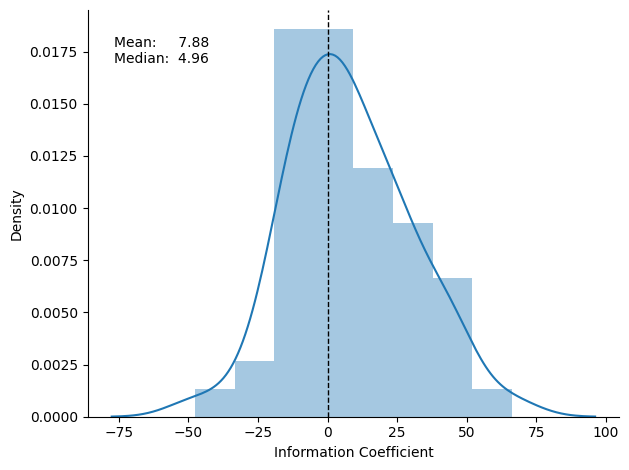

In [9]:
reg_eval.plot_ic_distribution(score_df)

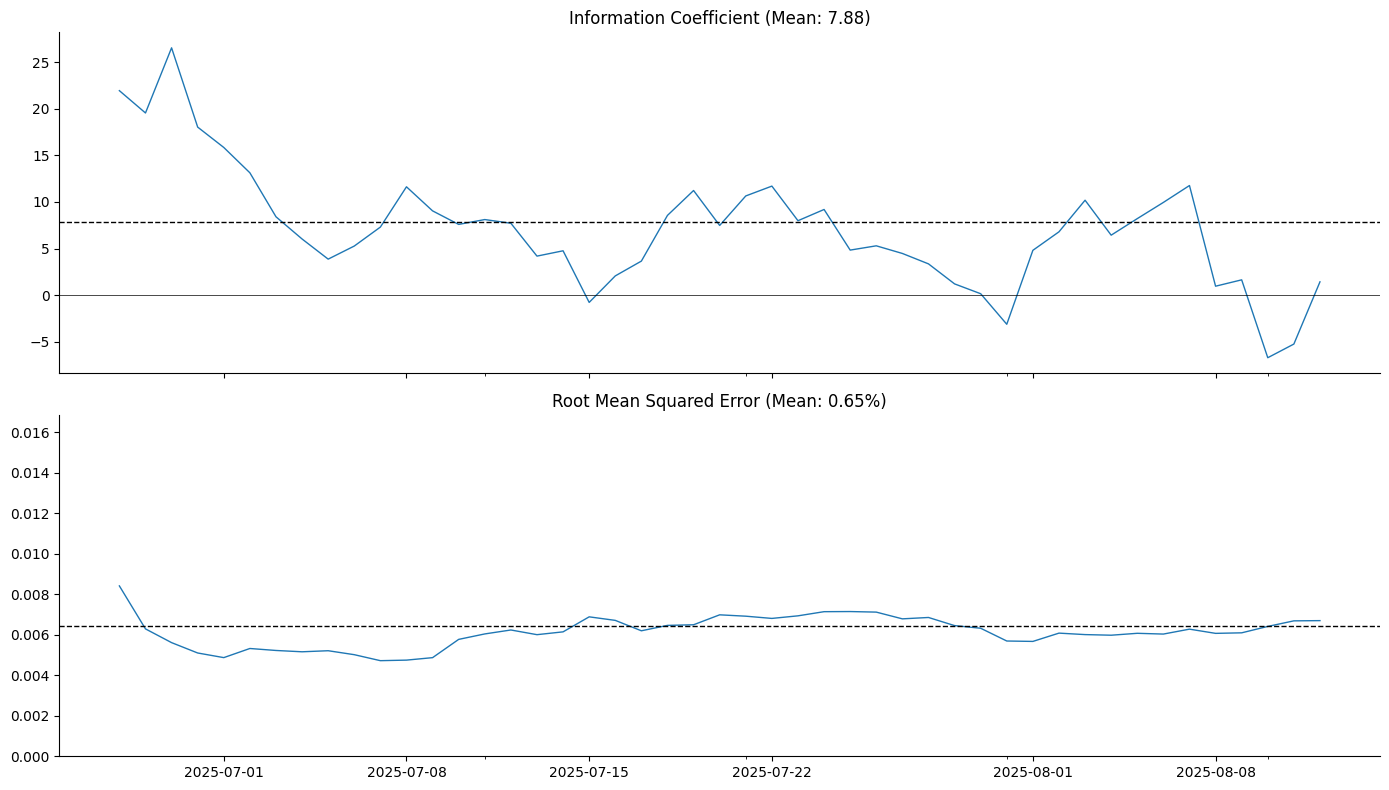

In [10]:
reg_eval.plot_rolling_ic(score_df)

<Figure size 1200x600 with 0 Axes>

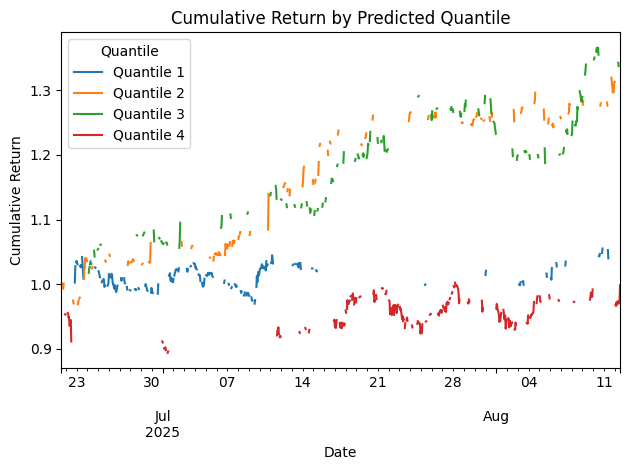

In [11]:
reg_eval.plot_cumulative_returns_by_quantile(pred_df=pred_df, n_bins=4)